<a href="https://colab.research.google.com/github/Irina-Bogdanova-bioinformatician/BI_ML_2023/blob/protein-stability/protein_stability_prediction/predict_protein_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [ ]:
from os.path import join
import pandas as pd

In [ ]:
data_folder = "data"
data_filename = "data.csv"
data_path = join(data_folder, data_filename)

## Data downloading and EDA

In [ ]:
!mkdir data/
!mv data.csv data/

In [ ]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [ ]:
data.shape

(31390, 4)

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31390 entries, 0 to 31389
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   protein_sequence  31390 non-null  object 
 1   pH                31104 non-null  float64
 2   data_source       28043 non-null  object 
 3   tm                31390 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.2+ MB


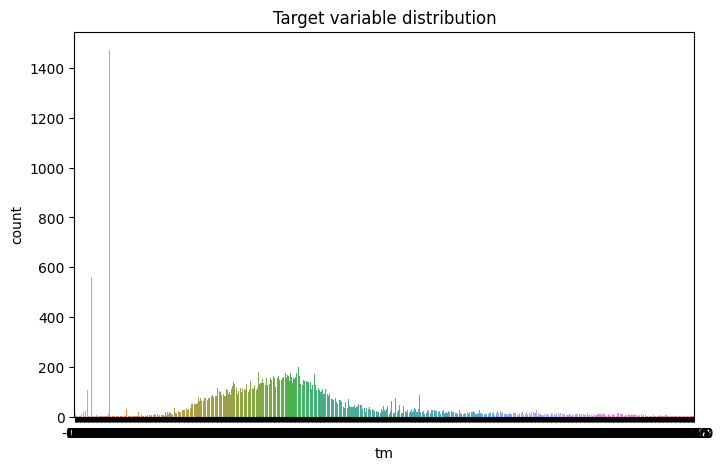

In [ ]:
# Check target destribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x="tm", data=data[["tm"]])
plt.title('Target variable distribution')
plt.show()

**Outlier processing**

In [ ]:
def outliers_number(df_in, param_name):
    q1 = df_in[param_name].quantile(0.25)
    q3 = df_in[param_name].quantile(0.75)
    iqr = q3 - q1
    boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
    outliers = df_in[param_name].loc[(df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])]
    n = len(outliers)
    return n   


def remove_outlier(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        changed_data = df_in.loc[(df_in[param_name] >= boxplot_range[0]) & (df_in[param_name] <= boxplot_range[1])]
    return changed_data


def outliers_to_median(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        new_condition = (df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])
        feature_median = df_in[param_name].median()
        df_in.loc[new_condition, param_name] = feature_median
    return df_in
  
    
def outliers_to_mean(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        new_condition = (df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])
        condition_mean = (df_in[param_name] >= boxplot_range[0]) | (df_in[param_name] <= boxplot_range[1])
        feature_mean = df_in[param_name].mean()
        df_in.loc[new_condition, param_name] = feature_mean
    return df_in


def outliers_clip(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        condition_1 = (df_in[param_name] < boxplot_range[0]) 
        condition_2 = (df_in[param_name] > boxplot_range[1])
        df_in.loc[condition_1, param_name] = boxplot_range[0]
        df_in.loc[condition_1, param_name] = boxplot_range[1]
    return df_in


- outliers_number function calculates the number of outliers in the sample;
- outliers_to_median function replaces outliers with median (takes dataset 
and the name of the feature by which outliers are determined as an input);
- remove_outlier function removes outliers;
- outliers_clip function acts like np.clip;
- outliers_to_mean function replaces outliers with averages.

The ends of the boxplot whiskers are calculated as the difference between the first quartile and one and a half interquartile distances and the sum of the third quartile and one and a half interquartile distances, respectively.

In [ ]:
quantative_features = data.drop(columns=['tm']).select_dtypes(include=['float64', 'int64']).columns.tolist()
for el in quantative_features:
    print(f"Outliers count for the {el} feature: {outliers_number(data, el)}")

Outliers count for the pH feature: 4642


As we can see there are quite a lot of outliers. There are several options to deal with them: for example, to leave unchanged, to delete such data, to change to something (median, mean or anything else), to make a clip (like in np.clip).

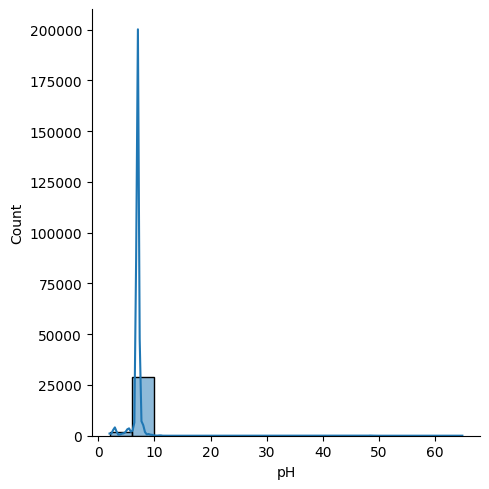

In [ ]:
sns.displot(data=data[["pH"]], x="pH", kde=True)

In [ ]:
# look at (1 quartile - 1.5 IQR) and (3 quartile + 1.5 IQR) - the ends of the boxplot whiskers 

q1 = data["pH"].quantile(0.25)
print("q1:", q1)
q3 = data["pH"].quantile(0.75)
print("q3", q3)
iqr = q3 - q1
boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
boxplot_range

q1: 7.0
q3 7.0


[7.0, 7.0]

So, all values except 7 are outliers.

The distribution of the average pH-optimum of protein stability is almost Gaussian with a mean at about pH=7, while the distribution of the average pH-optimum of activity shows several peaks. Perhaps, such difference indicates that activity is more sensitive to pH changes, while structural integrity can better sustain pH fluctuations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2911520/).

It's makes total sence as most living organisms function at the optimal pH range of 6.5 to 8.5. Our blood has a normal pH range of 7.35 to 7.45.  

In [ ]:
# let's look at rows with ph values > 14 as tese are abnormal

data[data["pH"] > 14]

,protein_sequence,pH,data_source,tm
seq_id,,,,
973,DTSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4,NaN,7.0
986,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVTFQNRESVLPT...,48.4,NaN,7.0
988,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,49.0,NaN,7.0
989,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFANRESVLPT...,55.6,NaN,5.5
1003,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESTLPT...,48.4,NaN,7.0
1012,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,48.4,NaN,7.0
1014,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,55.6,NaN,5.5
1018,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,49.0,NaN,7.0
1037,DVSGTVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,49.0,NaN,7.0


In [ ]:
data[data["pH"] > 14].shape

(29, 4)

In [ ]:
# let's remove them

data = data[data["pH"] < 14]

In [ ]:
data[data["pH"] > 14]

,protein_sequence,pH,data_source,tm
seq_id,,,,


In [ ]:
data.shape

(31075, 4)

**Handle the NaN values**

In [ ]:
# Let's look how many of NaN we have

for feature in data.columns:
    print(f"NaN count in {feature}: {data[feature].isna().sum()}")

NaN count in protein_sequence: 0
NaN count in pH: 0
NaN count in data_source: 3306
NaN count in tm: 0


The data_source feature is not important - we can delete it.

In [ ]:
data = data.drop(columns=["data_source"])
data

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6


## Feature space analysis

**Amino acid sequences encoding**

Let's encode amino acid sequences into numeric vectors

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6658705/

use iFeature package (https://github.com/Superzchen/iFeature/blob/master/iFeatureManual.pdf)

In [ ]:
!git clone https://github.com/Superzchen/iFeature

Cloning into 'iFeature'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 322 (delta 40), reused 33 (delta 29), pack-reused 275
Receiving objects: 100% (322/322), 6.72 MiB | 13.16 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [ ]:
!python3 iFeature/iFeature.py --help

usage: it's usage tip.

Generating
various
numerical r
epresentati
on schemes
for protein
sequences

options:
  -h, --help
    show this
    help
    message and
    exit
  --file FILE
    input fasta
    file
  --type {AAC,EAAC,CKSAAP,DPC,DDE,TPC,BINARY,GAAC,EGAAC,CKSAAGP,GDPC,GTPC,AAINDEX,ZSCALE,BLOSUM62,NMBroto,Moran,Geary,CTDC,CTDT,CTDD,CTriad,KSCTriad,SOCNumber,QSOrder,PAAC,APAAC,KNNprotein,KNNpeptide,PSSM,SSEC,SSEB,Disorder,DisorderC,DisorderB,ASA,TA}
    the
    encoding
    type
  --path FILEPATH
    data file
    path used
    for 'PSSM',
    'SSEB(C)', 
    'Disorder(B
    C)', 'ASA'
    and 'TA'
    encodings
  --train TRAINFILE
    training
    file in
    fasta
    format only
    used for 'K
    NNprotein'
    or 'KNNpept
    ide'
    encodings
  --label LABELFILE
    sample
    label file
    only used
    for 'KNNpro
    tein' or 'K
    NNpeptide'
    encodings
  --order {alphabetically,polarity,sideChainVolume,userDefined}
    output
    order for
    of Amino
    Acid

In [ ]:
!touch aa_seq.fasta # this file will contain all proteins sequences

In [ ]:
with open(f"aa_seq.fasta", "w") as fasta:
    for i, seq in data[["protein_sequence"]].iterrows():
        prot = seq["protein_sequence"]
        fasta.write(f">{i}\n")
        fasta.write(prot + "\n")


In [ ]:
!cat aa_seq.fasta | head -n 10

>0
AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR
>1
AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS
>2
AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYATLGVAKNANGKDIKKAYYQLAKKYHPDTNKEDPDAGRKFQEVSEAYEVLSDEQKRREYDTYGQTAENIGRQGGGFPGGGAGGFGPEGFSQSWQFRSSIDPEELFRKIFGEGNFRTNSFDDFADSKFGFGQAQEMVMDLTFAQAARGVNKDVNVNVVDQCPKCAGTKCEPGTKPGRCQYCNGTGFETVSTGPFVMRSTCRYCQGTRQHIKYPCSECEGKGRTVQRRKVTVPVPAGIENGQTVRMQVGSKELFVTFRVERSDYFRREGADVHTDAAISLAQAVLGGTVRVQGVYEDQWINVEPGTSSHHKIMLRGKGL

In [ ]:
!touch encoding_aac.tsv # amino acid composition (frequencies of each of 20 natural aa)

In [ ]:
!python iFeature/iFeature.py --file aa_seq.fasta --type AAC --out encoding_aac.tsv

Descriptor type: AAC


In [ ]:
!cat encoding_aac.tsv | head -n 10

#	A	C	D	E	F	G	H	I	K	L	M	N	P	Q	R	S	T	V	W	Y
0	0.13196480938416422	0.002932551319648094	0.03812316715542522	0.08797653958944282	0.03812316715542522	0.11143695014662756	0.008797653958944282	0.04105571847507331	0.0469208211143695	0.10850439882697947	0.02346041055718475	0.01466275659824047	0.05278592375366569	0.017595307917888565	0.07331378299120235	0.03225806451612903	0.04105571847507331	0.10850439882697947	0.011730205278592375	0.008797653958944282
1	0.0979020979020979	0.0	0.03496503496503497	0.18181818181818182	0.02097902097902098	0.06293706293706294	0.013986013986013986	0.045454545454545456	0.06643356643356643	0.08041958041958042	0.006993006993006993	0.02097902097902098	0.027972027972027972	0.07692307692307693	0.1048951048951049	0.04895104895104895	0.04195804195804196	0.045454545454545456	0.01048951048951049	0.01048951048951049
2	0.1006036217303823	0.018108651911468814	0.05432595573440644	0.06438631790744467	0.04225352112676056	0.13078470824949698	0.022132796780684104	0.03219315895372234	

In [ ]:
!wc encoding_aac.tsv

   31076   652596 12364208 encoding_aac.tsv


In [ ]:
encoded = []

with open("encoding_aac.tsv") as infile:
    lines = infile.readlines()
    column_list = lines[0].strip().split("\t")[1:]
    for line in lines[1:]:
        values_dict = {}
        line_elements = line.strip().split("\t")
        for i in range(len(line_elements) - 1):
            values_dict[f"aa_{column_list[i]}_freq"] = float(line_elements[i + 1])
        encoded.append(values_dict)

print(encoded[:3])

[{'aa_A_freq': 0.13196480938416422, 'aa_C_freq': 0.002932551319648094, 'aa_D_freq': 0.03812316715542522, 'aa_E_freq': 0.08797653958944282, 'aa_F_freq': 0.03812316715542522, 'aa_G_freq': 0.11143695014662756, 'aa_H_freq': 0.008797653958944282, 'aa_I_freq': 0.04105571847507331, 'aa_K_freq': 0.0469208211143695, 'aa_L_freq': 0.10850439882697947, 'aa_M_freq': 0.02346041055718475, 'aa_N_freq': 0.01466275659824047, 'aa_P_freq': 0.05278592375366569, 'aa_Q_freq': 0.017595307917888565, 'aa_R_freq': 0.07331378299120235, 'aa_S_freq': 0.03225806451612903, 'aa_T_freq': 0.04105571847507331, 'aa_V_freq': 0.10850439882697947, 'aa_W_freq': 0.011730205278592375, 'aa_Y_freq': 0.008797653958944282}, {'aa_A_freq': 0.0979020979020979, 'aa_C_freq': 0.0, 'aa_D_freq': 0.03496503496503497, 'aa_E_freq': 0.18181818181818182, 'aa_F_freq': 0.02097902097902098, 'aa_G_freq': 0.06293706293706294, 'aa_H_freq': 0.013986013986013986, 'aa_I_freq': 0.045454545454545456, 'aa_K_freq': 0.06643356643356643, 'aa_L_freq': 0.080419

In [ ]:
df_aac_encode = pd.DataFrame(encoded)
df_aac_encode

,aa_A_freq,aa_C_freq,aa_D_freq,aa_E_freq,aa_F_freq,aa_G_freq,aa_H_freq,aa_I_freq,aa_K_freq,aa_L_freq,aa_M_freq,aa_N_freq,aa_P_freq,aa_Q_freq,aa_R_freq,aa_S_freq,aa_T_freq,aa_V_freq,aa_W_freq,aa_Y_freq
0,0.131965,0.002933,0.038123,0.087977,0.038123,0.111437,0.008798,0.041056,0.046921,0.108504,0.023460,0.014663,0.052786,0.017595,0.073314,0.032258,0.041056,0.108504,0.011730,0.008798
1,0.097902,0.000000,0.034965,0.181818,0.020979,0.062937,0.013986,0.045455,0.066434,0.080420,0.006993,0.020979,0.027972,0.076923,0.104895,0.048951,0.041958,0.045455,0.010490,0.010490
2,0.100604,0.018109,0.054326,0.064386,0.042254,0.130785,0.022133,0.032193,0.078471,0.036217,0.012072,0.030181,0.040241,0.050302,0.062374,0.066398,0.060362,0.060362,0.006036,0.032193
3,0.075472,0.018868,0.071698,0.109434,0.045283,0.060377,0.026415,0.037736,0.064151,0.105660,0.007547,0.033962,0.060377,0.033962,0.037736,0.060377,0.071698,0.052830,0.011321,0.015094
4,0.059269,0.009649,0.053756,0.053756,0.022054,0.057891,0.027567,0.048932,0.046864,0.071675,0.021365,0.044797,0.088215,0.037216,0.043418,0.101999,0.082702,0.085458,0.011027,0.032391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31070,0.060109,0.021858,0.069217,0.056466,0.032787,0.092896,0.027322,0.038251,0.058288,0.083789,0.023679,0.043716,0.045537,0.043716,0.076503,0.060109,0.032787,0.076503,0.023679,0.032787
31071,0.078891,0.010661,0.044776,0.061834,0.046908,0.057569,0.046908,0.063966,0.042644,0.100213,0.029851,0.040512,0.040512,0.034115,0.053305,0.078891,0.055437,0.072495,0.010661,0.029851
31072,0.101562,0.007812,0.054688,0.054688,0.054688,0.085938,0.015625,0.046875,0.062500,0.046875,0.054688,0.039062,0.046875,0.062500,0.023438,0.078125,0.046875,0.054688,0.031250,0.031250
31073,0.079258,0.008432,0.057336,0.060708,0.038786,0.087690,0.018550,0.057336,0.059022,0.075885,0.043845,0.042159,0.052277,0.020236,0.042159,0.086003,0.053963,0.080944,0.005059,0.030354


In [ ]:
!touch encoding_gaac.tsv # grouped amino acid composition (20 aa types are further categorized into 5 classes according to their physicochemical properties)

In [ ]:
!python iFeature/iFeature.py --file aa_seq.fasta --type GAAC --out encoding_gaac.tsv

Descriptor type: GAAC


In [ ]:
!cat encoding_gaac.tsv | head -n 10

#	alphatic	aromatic	postivecharge	negativecharge	uncharge
0	0.5249266862170088	0.05865102639296188	0.12903225806451613	0.12609970674486803	0.16129032258064516
1	0.33916083916083917	0.04195804195804196	0.1853146853146853	0.21678321678321677	0.21678321678321677
2	0.3722334004024145	0.08048289738430583	0.16297786720321933	0.11871227364185111	0.2655935613682093
3	0.33962264150943394	0.07169811320754717	0.12830188679245283	0.1811320754716981	0.2792452830188679
4	0.34458993797381116	0.06547208821502412	0.11784975878704342	0.10751206064782909	0.3645761543762922
5	0.4394736842105263	0.09210526315789473	0.1368421052631579	0.09210526315789473	0.2394736842105263
6	0.4394736842105263	0.09210526315789473	0.1368421052631579	0.09210526315789473	0.2394736842105263
7	0.3554817275747508	0.07308970099667775	0.13953488372093023	0.11627906976744186	0.31561461794019935
8	0.4878048780487805	0.05574912891986063	0.11498257839721254	0.12195121951219512	0.21951219512195122


In [ ]:
!wc encoding_gaac.tsv

  31076  186456 3159211 encoding_gaac.tsv


In [ ]:
encoded = []

with open("encoding_gaac.tsv") as infile:
    lines = infile.readlines()
    column_list = lines[0].strip().split("\t")[1:]
    for line in lines[1:]:
        values_dict = {}
        line_elements = line.strip().split("\t")
        for i in range(len(line_elements) - 1):
            values_dict[column_list[i]] = float(line_elements[i + 1])
        encoded.append(values_dict)

print(encoded[:3])

[{'alphatic': 0.5249266862170088, 'aromatic': 0.05865102639296188, 'postivecharge': 0.12903225806451613, 'negativecharge': 0.12609970674486803, 'uncharge': 0.16129032258064516}, {'alphatic': 0.33916083916083917, 'aromatic': 0.04195804195804196, 'postivecharge': 0.1853146853146853, 'negativecharge': 0.21678321678321677, 'uncharge': 0.21678321678321677}, {'alphatic': 0.3722334004024145, 'aromatic': 0.08048289738430583, 'postivecharge': 0.16297786720321933, 'negativecharge': 0.11871227364185111, 'uncharge': 0.2655935613682093}]


In [ ]:
df_gaac_encode = pd.DataFrame(encoded)
df_gaac_encode

,alphatic,aromatic,postivecharge,negativecharge,uncharge
0,0.524927,0.058651,0.129032,0.126100,0.161290
1,0.339161,0.041958,0.185315,0.216783,0.216783
2,0.372233,0.080483,0.162978,0.118712,0.265594
3,0.339623,0.071698,0.128302,0.181132,0.279245
4,0.344590,0.065472,0.117850,0.107512,0.364576
...,...,...,...,...,...
31070,0.375228,0.089253,0.162113,0.125683,0.247723
31071,0.402985,0.087420,0.142857,0.106610,0.260128
31072,0.390625,0.117188,0.101562,0.109375,0.281250
31073,0.424958,0.074199,0.119730,0.118044,0.263069


In [ ]:
index = pd.Index([i for i in range(31075)])
data.set_index(index, inplace=True)
data

,protein_sequence,pH,tm
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
31070,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31071,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31072,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6
31073,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7


In [ ]:
# make df with new features

data_2 = pd.concat([data, df_aac_encode, df_gaac_encode], axis=1)
data_2

,protein_sequence,pH,tm,aa_A_freq,aa_C_freq,aa_D_freq,aa_E_freq,aa_F_freq,aa_G_freq,aa_H_freq,...,aa_S_freq,aa_T_freq,aa_V_freq,aa_W_freq,aa_Y_freq,alphatic,aromatic,postivecharge,negativecharge,uncharge
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,0.131965,0.002933,0.038123,0.087977,0.038123,0.111437,0.008798,...,0.032258,0.041056,0.108504,0.011730,0.008798,0.524927,0.058651,0.129032,0.126100,0.161290
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,0.097902,0.000000,0.034965,0.181818,0.020979,0.062937,0.013986,...,0.048951,0.041958,0.045455,0.010490,0.010490,0.339161,0.041958,0.185315,0.216783,0.216783
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,0.100604,0.018109,0.054326,0.064386,0.042254,0.130785,0.022133,...,0.066398,0.060362,0.060362,0.006036,0.032193,0.372233,0.080483,0.162978,0.118712,0.265594
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,0.075472,0.018868,0.071698,0.109434,0.045283,0.060377,0.026415,...,0.060377,0.071698,0.052830,0.011321,0.015094,0.339623,0.071698,0.128302,0.181132,0.279245
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,0.059269,0.009649,0.053756,0.053756,0.022054,0.057891,0.027567,...,0.101999,0.082702,0.085458,0.011027,0.032391,0.344590,0.065472,0.117850,0.107512,0.364576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31070,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,0.060109,0.021858,0.069217,0.056466,0.032787,0.092896,0.027322,...,0.060109,0.032787,0.076503,0.023679,0.032787,0.375228,0.089253,0.162113,0.125683,0.247723
31071,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,0.078891,0.010661,0.044776,0.061834,0.046908,0.057569,0.046908,...,0.078891,0.055437,0.072495,0.010661,0.029851,0.402985,0.087420,0.142857,0.106610,0.260128
31072,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,0.101562,0.007812,0.054688,0.054688,0.054688,0.085938,0.015625,...,0.078125,0.046875,0.054688,0.031250,0.031250,0.390625,0.117188,0.101562,0.109375,0.281250
31073,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,50.7,0.079258,0.008432,0.057336,0.060708,0.038786,0.087690,0.018550,...,0.086003,0.053963,0.080944,0.005059,0.030354,0.424958,0.074199,0.119730,0.118044,0.263069


In [ ]:
data_2.to_csv("new_features_added.csv")

In [ ]:
data_2 = pd.read_csv("new_features_added.csv", index_col=0)
data_2.head()

,protein_sequence,pH,tm,aa_A_freq,aa_C_freq,aa_D_freq,aa_E_freq,aa_F_freq,aa_G_freq,aa_H_freq,...,aa_S_freq,aa_T_freq,aa_V_freq,aa_W_freq,aa_Y_freq,alphatic,aromatic,postivecharge,negativecharge,uncharge
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,0.131965,0.002933,0.038123,0.087977,0.038123,0.111437,0.008798,...,0.032258,0.041056,0.108504,0.011730,0.008798,0.524927,0.058651,0.129032,0.126100,0.161290
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,0.097902,0.000000,0.034965,0.181818,0.020979,0.062937,0.013986,...,0.048951,0.041958,0.045455,0.010490,0.010490,0.339161,0.041958,0.185315,0.216783,0.216783
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,0.100604,0.018109,0.054326,0.064386,0.042254,0.130785,0.022133,...,0.066398,0.060362,0.060362,0.006036,0.032193,0.372233,0.080483,0.162978,0.118712,0.265594
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,0.075472,0.018868,0.071698,0.109434,0.045283,0.060377,0.026415,...,0.060377,0.071698,0.052830,0.011321,0.015094,0.339623,0.071698,0.128302,0.181132,0.279245
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,0.059269,0.009649,0.053756,0.053756,0.022054,0.057891,0.027567,...,0.101999,0.082702,0.085458,0.011027,0.032391,0.344590,0.065472,0.117850,0.107512,0.364576


**Correlation with target**

In [ ]:
target = 'tm'
features = data_2.columns.drop([target, "protein_sequence"]).tolist()
features

['pH',
 'aa_A_freq',
 'aa_C_freq',
 'aa_D_freq',
 'aa_E_freq',
 'aa_F_freq',
 'aa_G_freq',
 'aa_H_freq',
 'aa_I_freq',
 'aa_K_freq',
 'aa_L_freq',
 'aa_M_freq',
 'aa_N_freq',
 'aa_P_freq',
 'aa_Q_freq',
 'aa_R_freq',
 'aa_S_freq',
 'aa_T_freq',
 'aa_V_freq',
 'aa_W_freq',
 'aa_Y_freq',
 'alphatic',
 'aromatic',
 'postivecharge',
 'negativecharge',
 'uncharge']

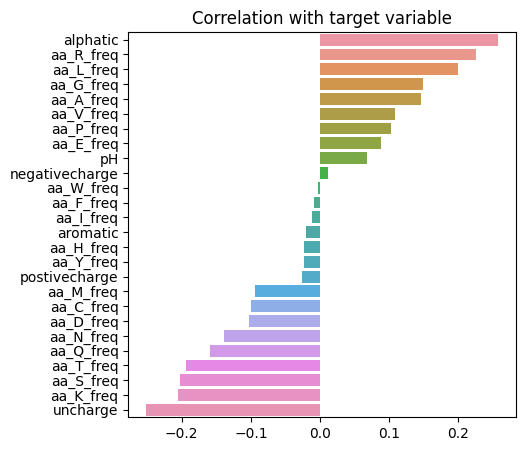

In [ ]:
corr_with_target = data_2[features + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(5, 5))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Correlation matrix**

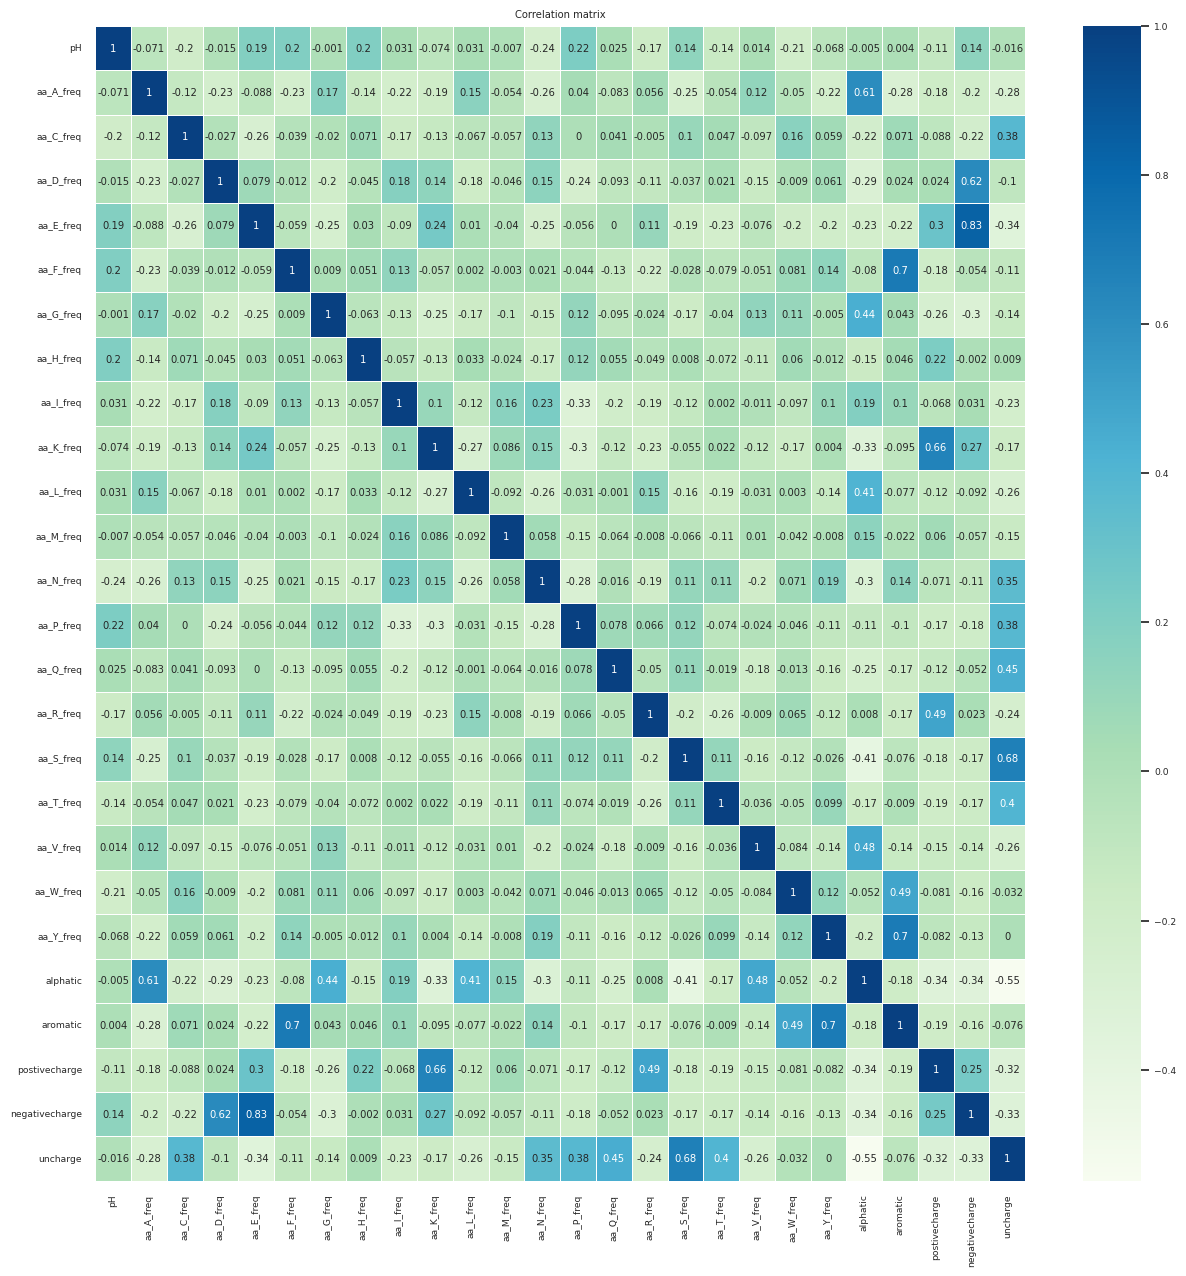

In [ ]:
plt.figure(figsize = (15, 15))

sns.set(font_scale=0.6)
sns.heatmap(data_2[features].corr().round(3), annot=True, linewidths=.4, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Train_Test_split

In [ ]:
from sklearn.model_selection import train_test_split

X = data_2[features]
y = data_2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [ ]:
X_train.shape

(21752, 26)

In [ ]:
y_train.shape

(21752,)

In [ ]:
X_test.shape

(9323, 26)

In [ ]:
y_test.shape

(9323,)

## Models building

**Logistic regression**

It seems to be not good choice, but let's try

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

In [ ]:
print(y_train)

902      44.6
6501     41.5
8192     41.0
14981    43.0
513      56.4
         ... 
29802    46.5
5390     82.7
860      58.9
15795    53.5
23654    35.9
Name: tm, Length: 21752, dtype: float64


In [ ]:
from sklearn import preprocessing
from sklearn import utils

y_copy = data_2[target].copy()

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y_copy)

#view transformed values
print(y_transformed)

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y_transformed, test_size=0.3, shuffle=True, random_state=42)

[529 277 177 ... 418 279 148]


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=21, shuffle=True)

model_lr = LogisticRegression()
model_lr.fit(X_train_lr, y_train_lr)

# evaluate model
cross_val_score(model_lr, X_train_lr, y_train_lr, scoring='accuracy', cv=cv, n_jobs=-1) # returns array of scores of the estimator for each run of the cross validation



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0.04550678, 0.04665594, 0.04643678, 0.04827586, 0.04344828])

In [ ]:
# evaluate model on test
cross_val_score(model_lr, X_test_lr, y_test_lr, scoring='accuracy', cv=cv, n_jobs=-1)

array([0.04075067, 0.03914209, 0.04450402, 0.03648069, 0.04184549])

Bad model, let's try other

**RandomForestRegressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV

In [ ]:
# Find optimal values fro n_estimators, max_depth parameters
depths = list(np.arange(3, 15))
depths.append(None)
parameters = [{'n_estimators': [10, 50, 100, 300, 400, 500], 
               'max_depth': depths}]
clf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=parameters, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

# n_estimators':  500, max_depth: None


In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [ ]:
forest = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=None)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

r2_test_forest1 = r2_score(y_test, y_test_pred)
r2_train_forest1 = r2_score(y_train, y_train_pred)

print(f"R2 for train: {r2_train_forest1}.\nR2 for test: {r2_test_forest1}")


R2 for train: 0.8977073498248391.
R2 for test: 0.6000382887794447


In [ ]:
# cross-validation

cv_score = cross_val_score(forest, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
print(f"cv_score: {cv_score}, cv_score.mean():{cv_score.mean()}")

cv_score: [0.60050306 0.56799084 0.59575885], cv_score.mean():0.588084246729777


In [ ]:
# Assess features importance

feature_importances = pd.DataFrame(zip(X_train.columns, forest.feature_importances_), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
25,uncharge,0.187031
9,aa_K_freq,0.091810
0,pH,0.088643
8,aa_I_freq,0.065341
14,aa_Q_freq,0.057162
13,aa_P_freq,0.052361
17,aa_T_freq,0.035468
16,aa_S_freq,0.032662
11,aa_M_freq,0.031829
12,aa_N_freq,0.031259


In [ ]:
less_important = feature_importances['feature_name'][feature_importances['importance'] < 0.02]
list(less_important)

['aa_E_freq',
 'aa_F_freq',
 'aa_H_freq',
 'aa_W_freq',
 'alphatic',
 'aromatic',
 'postivecharge',
 'negativecharge']

In [ ]:
train_df_preprocessed = X_train.copy().drop(less_important, axis = 1)
test_df_preprocessed = X_test.copy().drop(less_important, axis = 1)

In [ ]:
forest_2 = RandomForestRegressor(n_estimators=500, random_state=42)
forest_2.fit(train_df_preprocessed, y_train)
y_train_pred_forest2 = forest_2.predict(train_df_preprocessed)
y_test_pred_forest2 = forest_2.predict(test_df_preprocessed)

r2_test_forest2 = r2_score(y_test, y_test_pred_forest2)
r2_train_forest2 = r2_score(y_train, y_train_pred_forest2)

print(f"R2 for train: {r2_train_forest2}.\nR2 for test: {r2_test_forest2}")

R2 for train: 0.8949631738380606.
R2 for test: 0.5931198048743938


**CatBoost**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.1 MB/s eta 0:00:00


In [ ]:
import catboost as catb

In [ ]:
model_catb = catb.CatBoostRegressor(loss_function="RMSE", silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred_ctb = model_catb.predict(X_train)
y_test_pred_ctb = model_catb.predict(X_test)

In [ ]:
r2_test_ctb = r2_score(y_test, y_test_pred_ctb)
r2_train_ctb = r2_score(y_train, y_train_pred_ctb)

print(f"R2 for train: {r2_train_ctb}.\nR2 for test: {r2_test_ctb}")

R2 for train: 0.7497067756954594.
R2 for test: 0.6216988307511448


In [ ]:
# Selection of hyperparameters for model catboost

model_catb = catb.CatBoostRegressor(loss_function="RMSE", random_state=42)

params = {'n_estimators':[10, 25, 50, 100, 200, 500],
          'max_depth':[3, 5, 7, 10, 15, None]}

cv=KFold(n_splits=3, random_state=42, shuffle=True)

rs = RandomizedSearchCV(model_catb, params, scoring='r2', cv=cv, n_jobs=-1)

rs.fit(X_train, y_train)

rs.best_params_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Learning rate set to 0.246472
0:	learn: 13.0337964	total: 18.9ms	remaining: 3.75s
1:	learn: 12.2853032	total: 34.2ms	remaining: 3.39s
2:	learn: 11.6996371	total: 52.3ms	remaining: 3.43s
3:	learn: 11.2401221	total: 74.8ms	remaining: 3.67s
4:	learn: 10.9636185	total: 88.9ms	remaining: 3.47s
5:	learn: 10.7106152	total: 103ms	remaining: 3.34s
6:	learn: 10.4932674	total: 119ms	remaining: 3.29s
7:	learn: 10.3275596	total: 135ms	remaining: 3.23s
8:	learn: 10.1762068	total: 149ms	remaining: 3.16s
9:	learn: 10.0872418	total: 163ms	remaining: 3.1s
10:	learn: 9.9431471	total: 178ms	remaining: 3.06s
11:	learn: 9.8553738	total: 192ms	remaining: 3.01s
12:	learn: 9.7471399	total: 211ms	remaining: 3.04s
13:	learn: 9.6783017	total: 225ms	remaining: 2.98s
14:	learn: 9.6237358	total: 238ms	remaining: 2.94s
15:	learn: 9.5472328	total: 253ms	remaining: 2.91s
16:	learn: 9.5038448	total: 267ms	remaining: 2.88s
17:	learn: 9.4325400	total: 281ms	remaining: 2.84s
18:	learn: 9.3756468	total: 296ms	remaining: 2.8

{'n_estimators': 200, 'max_depth': 7}

In [ ]:
model_catb_final = catb.CatBoostRegressor(n_estimators=200, max_depth=7,
                                      silent=True, loss_function="RMSE", random_state=42)

model_catb_final.fit(X_train, y_train)

y_train_pred_catb = model_catb_final.predict(X_train)
y_test_pred_catb = model_catb_final.predict(X_test)



In [ ]:
r2_test_catb = r2_score(y_test, y_test_pred_catb)
r2_train_catb = r2_score(y_train, y_train_pred_catb)

print(f"R2 for train: {r2_train_catb}.\nR2 for test: {r2_test_catb}")

R2 for train: 0.7534823159501589.
R2 for test: 0.6098698654554552


**Light auto ML**

In [ ]:
!pip install -U lightautoml

You should consider upgrading via the 'C:\Users\User\anaconda3\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: lightautoml
    Found existing installation: lightautoml 0.3.1
    Uninstalling lightautoml-0.3.1:
      Successfully uninstalled lightautoml-0.3.1


In [ ]:
!pip install torch==1.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
import pandas as pd
import torch

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error

In [ ]:
X_y_train = X_train.copy()
X_y_train["target"] = y_train

In [ ]:
TASK = Task('reg', loss = 'mse', metric = 'r2', greater_is_better=False)
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42
TEST_SIZE = 0.3
TARGET_NAME = "target"
roles = {"target": TARGET_NAME}



In [ ]:
automl_model = TabularAutoML(task=TASK,
                            timeout=30000,
                            cpu_limit = N_THREADS,
                            gpu_ids='all',
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                            general_params={'use_algos': [['lgb_tuned', 'cb_tuned', 'cb'],['lgb_tuned', 'cb']]},
                            tuning_params={'max_tuning_iter': 20},
                      )


In [ ]:
train_pred_automl = automl_model.fit_predict(X_y_train, roles = roles, verbose = 1)

[09:03:00] Stdout logging level is INFO.
[09:03:00] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[09:03:00] Task: reg

[09:03:00] Start automl preset with listed constraints:
[09:03:00] - time: 30000.00 seconds
[09:03:00] - CPU: 8 cores
[09:03:00] - memory: 16 GB

[09:03:00] Train data shape: (21752, 27)

[09:03:13] Layer 1 train process start. Time left 29987.41 secs
[09:03:37] Selector_LightGBM fitting and predicting completed
[09:03:41] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs
[09:08:58] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM completed
[09:08:58] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ...
[09:10:22] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.6143668125566992
[09:10:22] Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed
[09:10:23] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[09:11:29] Fitting Lv

In [ ]:
test_pred_automl = automl_model.predict(X_test)
test_pred_automl

array([[67.65975 ],
       [89.647675],
       [42.776344],
       ...,
       [30.620234],
       [52.52799 ],
       [44.470486]], dtype=float32)

In [ ]:
print(type(y_test))
y_test

<class 'pandas.core.series.Series'>


9202     75.1
2622     88.2
11082    39.8
26483    41.7
12608    44.0
         ... 
26087    38.5
28305    63.9
16938    20.0
26164    47.0
5719     44.3
Name: tm, Length: 9323, dtype: float64

In [ ]:
test_pred_automl_ = np.array([x.data[0] for x in test_pred_automl])

In [ ]:
train_pred_automl_ = np.array([x.data[0] for x in train_pred_automl])

In [ ]:
y_test_ = y_test.copy()
y_test_ = np.array(y_test_)
print(type(y_test_))
y_test_

<class 'numpy.ndarray'>


array([75.1, 88.2, 39.8, ..., 20. , 47. , 44.3])

In [ ]:
y_train_ = y_train.copy()
y_train_ = np.array(y_train_)
print(type(y_train_))
y_train_

<class 'numpy.ndarray'>


array([44.6, 41.5, 41. , ..., 58.9, 53.5, 35.9])

In [ ]:
print(type(test_pred_automl))
test_pred_automl

<class 'lightautoml.dataset.np_pd_dataset.NumpyDataset'>


array([[67.65975 ],
       [89.647675],
       [42.776344],
       ...,
       [30.620234],
       [52.52799 ],
       [44.470486]], dtype=float32)

In [ ]:
r2_test_automl = r2_score(y_test_, test_pred_automl_)
r2_train_automl = r2_score(y_train_, train_pred_automl_)

print(f"R2 for train: {r2_train_automl}.\nR2 for test: {r2_test_automl}")

R2 for train: 0.6090319001356186.
R2 for test: 0.6020881685326214


## Final model selection

CatBoost and RandomForest were the best in r2 scores for both train and test 